In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# check pytorch version
torch.__version__

'1.10.0'

## 1.Data (prepaing and Loading)

In [7]:
# create 'known' parameters
weight = 0.6
bias = 0.2

# create data 
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.2000],
         [0.2120],
         [0.2240],
         [0.2360],
         [0.2480],
         [0.2600],
         [0.2720],
         [0.2840],
         [0.2960],
         [0.3080]]))

### Split data into training and test sets 

In [8]:
# create train/test split
train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [19]:
def plot_predictions(train_data = X_train, 
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
    
    plt.figure(figsize=(10, 7))

    plt.scatter(train_data, train_labels, c='b', s=4, label="Training data")

    plt.scatter(test_data, test_labels, c = 'g', s = 4, label = 'Test data')

    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label='predictions')

    plt.legend(prop={'size':14})    
    

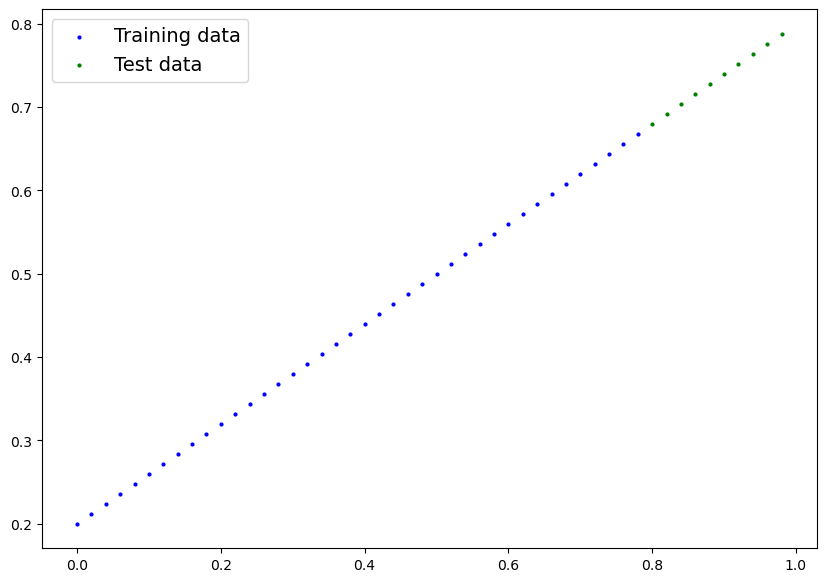

In [18]:
plot_predictions();